In [3]:
import numpy as np
import torch
import sys

sys.path.append("../")
from torch.utils.data import DataLoader
from evaluation.calc_stats import *
from vi_rnn.datasets import *
from vi_rnn.saving import load_model
from py_rnn.train import load_rnn
import matplotlib.pyplot as plt
from vi_rnn.utils import *
import matplotlib as mpl
from fixed_points.find_fixed_points_analytic import find_fixed_points_analytic
from fixed_points.stability import PL_Jacobian
from matplotlib.markers import MarkerStyle
from matplotlib.colors import colorConverter as cc
import copy

%matplotlib inline

## Panel A and D

In [4]:
# Load teacher RNN
rnn_osc, _, _, _ = load_rnn("../data/student_teacher/osc_rnn")
U, V, B = extract_orth_basis_rnn(rnn_osc)

# Load student RNN
mod = "../models/students/SW20_1000_new"
vae, vae_params, task_params, training_params = load_model(mod, load_encoder=False)

vae = orthogonalise_network(vae)

using ReLU activation
using uniform init


UnboundLocalError: local variable 'chol_cov_embed' referenced before assignment

In [ ]:
task_params["n_trials"], training_params["n_epochs"]

(200, 1000)

In [ ]:
# make a dataset using the teacher RNN
batch_size = 1
task_params["dur"] = 10000
task_params["n_trials"] = 1
task_params["r0"] = 1
task = Oscillations_Cont(task_params, U, V, B)
data_loader = DataLoader(task, batch_size=batch_size, shuffle=True)

# extract ground truth data
ratesGT = task.data[0]
latent_codeGT = task.latents[0]
x0_hat = ratesGT[:,0]

In [ ]:
# run the student RNN
with torch.no_grad():
    data = task.data[0]
    z0 = vae.rnn.inv_observation(x0_hat.unsqueeze(0).unsqueeze(-1))
    dim_x = vae.dim_x
    dur = task_params["dur"]
    Z = vae.rnn.get_latent_time_series(time_steps=dur, z0=z0)
    Zn = Z.cpu().detach().numpy()[0, :, :, 0]
    data_gen = vae.rnn.get_observation(Z, noise_scale=1)[0, :, :, 0]

no input


In [ ]:
# Extract phase planes
xlims = 3
ylims = 3
X, Y, uGT, vGT, normGT = extract_phase_plane_rnn(rnn_osc, xlims, ylims)
X, Y, u, v, norm = extract_phase_plane_vae(vae, xlims, ylims)

In [ ]:
ratesGT.shape

torch.Size([20, 10000])

In [ ]:
latent_codeGT.shape

torch.Size([2, 10000])

In [ ]:
data_gen.shape

torch.Size([20, 10000])

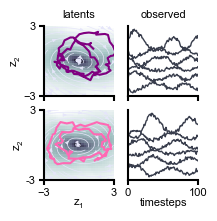

In [ ]:
# Make panel A
with mpl.rc_context(fname="matplotlibrc"):
    fig, ax = plt.subplots(2, 2, figsize=(2, 2))

    T1 = 150
    T2 = 250
    lT1 = 150
    lT2 = 250
    ax[0, 0].set_box_aspect(1)
    ax[0, 0].spines[["right", "top"]].set_visible(False)
    ax[0, 0].imshow(
        normGT,
        extent=[-xlims, xlims, -ylims, ylims],
        origin="lower",
        cmap="bone",
        vmax=np.max(normGT),
        aspect="auto",
    )
    ax[0, 0].streamplot(
        X, Y, uGT, vGT, color="lavender", density=0.5, linewidth=0.5, arrowsize=0.5
    )

    ax[0, 0].set_xlim(-xlims, xlims)
    ax[0, 0].set_ylim(-ylims, ylims)
    ax[0, 0].set_xticks([])
    ax[0, 0].set_yticks([-ylims, ylims])
    ax[0, 0].set_ylabel(r"$z_2$")
    ax[0, 0].plot(
        latent_codeGT[0, lT1:lT2].numpy(),
        latent_codeGT[1, lT1:lT2].numpy(),
        color="purple",
        alpha=1,
    )

    for i in range(6):
        ax[0, 1].plot(ratesGT[i, T1:T2] + i * 1, color="#393e4d", alpha=1, lw=1)
    # ax[0, 1].set_box_aspect(1)
    ax[0, 1].set_xlim(0, T2 - T1)
    ax[0, 1].spines[["right", "top"]].set_visible(False)
    ax[0, 1].set_yticks([])
    ax[0, 1].set_yticklabels([])

    ax[0, 1].set_xticks([])
    ax[0, 0].set_title("latents")
    ax[0, 1].set_title("observed")

    ax[1, 0].imshow(
        norm,
        extent=[-xlims, xlims, -ylims, ylims],
        origin="lower",
        cmap="bone",
        vmax=np.max(norm),
        aspect="auto",
    )
    ax[1, 0].streamplot(
        X, Y, u, v, color="lavender", density=0.5, linewidth=0.5, arrowsize=0.5
    )
    ax[1, 0].set_box_aspect(1)
    ax[1, 0].spines[["right", "top"]].set_visible(False)

    ax[1, 0].set_xlim(-xlims, xlims)
    ax[1, 0].set_ylim(-ylims, ylims)
    ax[1, 0].set_xticks([-xlims, xlims])
    ax[1, 0].set_yticks([-ylims, ylims])
    ax[1, 0].set_xlabel(r"$z_1$")
    ax[1, 0].set_ylabel(r"$z_2$")
    ax[1, 0].plot(Zn[0, lT1:lT2], Zn[1, lT1:lT2], color="hotpink")  # ,lw=1)

    ax[0, 0].set_xticks([-xlims, xlims])
    ax[0, 0].set_xticklabels([])
    ax[0, 1].set_xticks([0, T2 - T1])
    ax[0, 1].set_xticklabels([])
    ax[1, 1].set_xticks([0, T2 - T1])

    for i in range(6):
        ax[1, 1].plot(data_gen[i, T1:T2] + i * 1, color="#393e4d", alpha=1, lw=1)
    # ax[1, 1].set_box_aspect(1)
    ax[1, 1].set_xlim(0, T2 - T1)
    ax[1, 1].spines[["right", "top"]].set_visible(False)
    ax[1, 1].set_yticks([])
    ax[1, 1].set_yticklabels([])
    ax[1, 1].set_xlabel("timesteps")
    ax[1, 0].set_yticklabels([-xlims, xlims])

    plt.savefig("../figures/Fig3A.pdf")

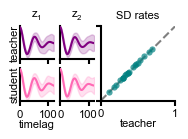

In [ ]:
# Make Panel D
fig = plt.figure(figsize=(2, 1))
gs1 = fig.add_gridspec(nrows=2, ncols=4)
ax1 = fig.add_subplot(gs1[:2, 2:])
ax21 = fig.add_subplot(gs1[1, 0])
ax22 = fig.add_subplot(gs1[1, 1], sharex=ax21, sharey=ax21)
ax12 = fig.add_subplot(gs1[0, 0], sharex=ax21, sharey=ax21)
ax11 = fig.add_subplot(gs1[0, 1], sharex=ax21, sharey=ax21)

# Compare SDs
ax1.scatter(
    torch.std(ratesGT, axis=-1),
    torch.std(data_gen, axis=-1),
    color="teal",
    alpha=0.7,
    s=20,
    linewidths=0,
)
ax1.plot([0, 1], [0, 1], color="grey", linestyle="--", zorder=-10)

# Compare cross correlations
lag = 120
dur = 9500
Corrs = estimate_cross_correlation(Zn[1], lag=lag, len=dur)
mean = np.mean(Corrs, axis=0)
std = np.std(Corrs, axis=0) * 1
ax22.plot(np.mean(Corrs, axis=0), color="hotpink", zorder=1000)
ax22.fill_between(
    np.arange(lag + 1), mean - std, mean + std, alpha=0.2, color="hotpink"
)
Corrs = []
Corrs = estimate_cross_correlation(Zn[0], lag=lag, len=dur)

mean = np.mean(Corrs, axis=0)
std = np.std(Corrs, axis=0) * 1
ax21.plot(np.mean(Corrs, axis=0), color="hotpink", zorder=1000)
ax21.fill_between(
    np.arange(lag + 1), mean - std, mean + std, alpha=0.2, color="hotpink"
)

ax11.hist(latent_codeGT[1].flatten(), density=True, color="purple", bins=20)
Corrs = estimate_cross_correlation(latent_codeGT[1], lag=lag, len=dur)
mean = np.mean(Corrs, axis=0)
std = np.std(Corrs, axis=0) * 1
ax11.plot(mean, color="purple", zorder=1000)
ax11.fill_between(np.arange(lag + 1), mean - std, mean + std, alpha=0.2, color="purple")

Corrs = estimate_cross_correlation(latent_codeGT[0], lag=lag, len=dur)
mean = np.mean(Corrs, axis=0)
std = np.std(Corrs, axis=0) * 1
ax12.plot(np.mean(Corrs, axis=0), color="purple", zorder=1000)
ax12.fill_between(np.arange(lag + 1), mean - std, mean + std, alpha=0.2, color="purple")


ax1.set_title("Latents hist")
ax1.set_title("SD rates")
ax1.set_xlabel("teacher")

ax1.set_yticks([0, 1])
ax1.set_xticks([0, 1])
ax1.set_yticklabels([])
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax1.set_box_aspect(1)
ax21.set_box_aspect(1)
ax22.set_box_aspect(1)
ax12.set_box_aspect(1)
ax11.set_box_aspect(1)

ax21.set_xticklabels([])
ax11.set_title(r"$z_2$")
ax12.set_title(r"$z_1$")
ax21.set_xlabel("timelag")
ax12.set_ylabel("teacher")
ax21.set_ylabel("student")

plt.setp(ax12.get_xticklabels(), visible=False)  # top left
plt.setp(ax11.get_xticklabels(), visible=False)  # top right
ax12.set_yticks([])
plt.setp(ax21.get_yticks(), visible=False)  # bottom left
ax12.set_xticks([0, 100])
ax12.set_xticklabels([0, 100])
ax12.set_xlim(0, 120)
# set wspace

plt.savefig("../figures/Fig3D.svg")

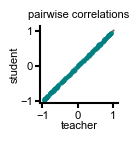

In [ ]:
# Make Supplementary
test_correlation = calculate_correlation(ratesGT.T)
gen_correlation = calculate_correlation(data_gen.T)

i_upper = np.triu_indices(task_params["n_neurons"], k=1)
test_corr_values = test_correlation[i_upper]
gen_corr_values = gen_correlation[i_upper]

plt.figure(figsize=(1, 1))
plt.scatter(
    test_corr_values, gen_corr_values, color="teal", alpha=0.7, linewidth=0, s=10
)
plt.title("pairwise correlations")
plt.xlabel("teacher")
plt.ylabel("student")

max = np.max([test_corr_values, gen_corr_values]) * 1.1
plt.plot([0, max], [0, max], color="grey", linestyle="--", zorder=-10)
plt.savefig("../figures/Supp_PWA.svg")

# Panel B and E

In [ ]:
# load teacher model
rnn_osc_poisson, _, _, _ = load_rnn("../data/student_teacher/osc_rnn_poisson")
U, V, B = extract_orth_basis_rnn(rnn_osc_poisson)

# load student model
vae, vae_params, task_params, training_params = load_model(
    "../models/students/Sine_Poisson"
)
vae_orth = copy.deepcopy(vae)
vae_orth = orthogonalise_network(vae_orth)

using ReLU activation
using uniform init
weight scaler 1
using causal circular padding


In [ ]:
task_params["dur"] = 10000
task_params["n_trials"] = 1
task_params["r0"] = 1
task = Oscillations_Poisson(task_params, U, V, B)
data_loader = DataLoader(task, batch_size=batch_size, shuffle=True)

# extract ground truth data
ratesGT = task.data[0]
latent_codeGT = task.latents[0]
x0_hat = ratesGT[:,0]

In [ ]:
# Extract phase planes
xlims = 3
ylims = 3
XGT, YGT, uGT, vGT, normGT = extract_phase_plane_rnn(rnn_osc_poisson, xlims, ylims)
xlims_inf = [3, 14]
ylims_inf = [-9, 5]
X, Y, u, v, norm = extract_phase_plane_vae(vae_orth, xlims_inf, ylims_inf)

In [ ]:
with torch.no_grad():
    data = task.data
    z0 = vae.rnn.inv_observation(x0_hat.unsqueeze(0).unsqueeze(-1))
    dim_x = vae.dim_x
    dur = task_params["dur"]
    Z = vae.rnn.get_latent_time_series(time_steps=dur, z0=z0, noise_scale=1)
    Zn = Z.cpu().detach().numpy()[0, :, :, 0]
    data_gen = vae.rnn.get_observation(Z).permute(0, 2, 1, 3).reshape(dur, dim_x).T
    data_gen = torch.poisson(data_gen)
    A = get_orth_proj_latents(vae)
    Zn = A @ Zn

no input


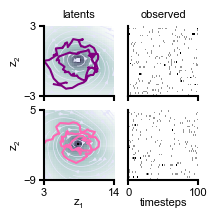

In [ ]:
# Make panel B

vmax = 2  # for Poisson
with mpl.rc_context(fname="matplotlibrc"):
    fig, ax = plt.subplots(2, 2, figsize=(2, 2))

    T1 = 150
    T2 = 250
    lT1 = 150
    lT2 = 250
    ax[0, 0].set_box_aspect(1)
    ax[0, 0].spines[["right", "top"]].set_visible(False)
    ax[0, 0].imshow(
        normGT,
        extent=[-xlims, xlims, -ylims, ylims],
        origin="lower",
        cmap="bone",
        vmax=np.max(normGT),
        aspect="auto",
    )
    ax[0, 0].streamplot(
        XGT, YGT, uGT, vGT, color="lavender", density=0.5, linewidth=0.5, arrowsize=0.5
    )

    ax[0, 0].set_xlim(-xlims, xlims)
    ax[0, 0].set_ylim(-ylims, ylims)
    ax[0, 0].set_xticks([-xlims, xlims])
    ax[0, 0].set_xticklabels([])
    ax[0, 0].set_yticks([-ylims, ylims])
    ax[0, 0].set_ylabel(r"$z_2$")
    ax[0, 0].plot(
        latent_codeGT[0, lT1:lT2].numpy(),
        latent_codeGT[1, lT1:lT2].numpy(),
        color="purple",
        alpha=1,
    )

    ax[0, 1].imshow(ratesGT[:, T1:T2], cmap="Greys", aspect="auto", vmax=vmax)

    ax[0, 1].set_xlim(0, T2 - T1)

    ax[0, 1].spines[["right", "top"]].set_visible(False)
    ax[0, 1].set_yticks([])
    ax[0, 1].set_yticklabels([])
    ax[0, 1].set_xticks([])
    ax[0, 0].set_title("latents")
    ax[0, 1].set_title("observed")
    ax[0, 1].set_box_aspect(1)

    ax[1, 0].imshow(
        norm,
        extent=[xlims_inf[0], xlims_inf[1], ylims_inf[0], ylims_inf[1]],
        origin="lower",
        cmap="bone",
        vmax=np.max(norm),
        aspect="auto",
    )
    ax[1, 0].streamplot(
        X, Y, u, v, color="lavender", density=0.5, linewidth=0.5, arrowsize=0.5
    )
    ax[1, 0].set_box_aspect(1)
    ax[1, 0].spines[["right", "top"]].set_visible(False)

    ax[1, 0].set_xlim(xlims_inf[0], xlims_inf[1])
    ax[1, 0].set_ylim(ylims_inf[0], ylims_inf[1])
    ax[1, 0].set_xticks([xlims_inf[0], xlims_inf[1]])
    ax[1, 0].set_yticks([ylims_inf[0], ylims_inf[1]])
    ax[1, 0].set_xlabel(r"$z_1$")
    ax[1, 0].set_ylabel(r"$z_2$")
    ax[1, 0].plot(Zn[0, lT1:lT2], Zn[1, lT1:lT2], color="hotpink")

    ax[1, 1].imshow(data_gen[:, T1:T2], cmap="Greys", aspect="auto", vmax=vmax)

    ax[1, 1].set_box_aspect(1)
    ax[1, 1].set_xlim(0, T2 - T1)
    ax[1, 1].set_xticks([0, T2 - T1])

    ax[1, 1].spines[["right", "top"]].set_visible(False)
    ax[1, 1].set_yticks([])
    ax[0, 1].set_xticks([0, T2 - T1])
    ax[0, 1].set_xticklabels([])
    ax[1, 1].set_yticklabels([])
    ax[1, 1].set_xlabel("timesteps")

    plt.savefig("../figures/Fig3B.svg")

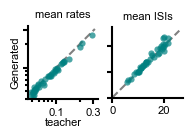

In [ ]:
# Make panel D

spikes_hat = ratesGT.T.detach().numpy()
spikes = data_gen.T.detach().numpy()
bins = np.linspace(0, 100, 100)
CVs_isi, Means_isi, Std_isi = calc_isi_stats(spikes)
CVs_isi_hat, Means_isi_hat, Std_isi_hat = calc_isi_stats(spikes_hat)
Means = np.mean(spikes, axis=0)
Means_hat = np.mean(spikes_hat, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(2, 1))

ax[0].set_ylabel("Generated")
ax[0].set_xlabel("teacher")

ax[1].scatter(Means_isi, Means_isi_hat, color="teal", alpha=0.7, s=20, linewidth=0)
ax[1].set_title("mean ISIs")
max = np.max([Means_isi, Means_isi_hat]) * 1.1
ax[1].plot([0, max], [0, max], color="grey", linestyle="--", zorder=-1000)
ax[1].set_aspect(1)

ax[0].scatter(Means, Means_hat, color="teal", alpha=0.7, s=20, linewidth=0)
ax[0].set_title("mean rates")
max = np.max([Means, Means_hat]) * 1.1
ax[0].plot([0, max], [0, max], color="grey", linestyle="--", zorder=-1000)
ax[0].set_aspect(1)

ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([0.1, 0.3])
ax[0].set_yticks([0.1, 0.3])
ax[1].set_xlim(0)
ax[1].set_ylim(0)

from matplotlib.ticker import StrMethodFormatter, NullFormatter

ax[0].yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
ax[0].yaxis.set_minor_formatter(NullFormatter())
ax[0].xaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
ax[0].xaxis.set_minor_formatter(NullFormatter())
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])

plt.savefig("../figures/Fig3E")

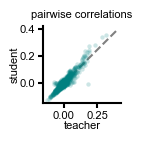

In [ ]:
# Supplementary
test_correlation = calculate_correlation(ratesGT.T)
gen_correlation = calculate_correlation(data_gen.T)

i_upper = np.triu_indices(task_params["n_neurons"], k=1)
test_corr_values = test_correlation[i_upper]
gen_corr_values = gen_correlation[i_upper]

plt.figure(figsize=(1, 1))
plt.scatter(
    test_corr_values, gen_corr_values, color="teal", alpha=0.2, linewidth=0, s=10
)
plt.title("pairwise correlations")
plt.xlabel("teacher")
plt.ylabel("student")
max = np.max([test_corr_values, gen_corr_values]) * 1.1
plt.plot([0, max], [0, max], color="grey", linestyle="--", zorder=-10)
plt.savefig("../figures/Supp_PWB.svg")

### Panel C and F

In [ ]:
# load teacher model
rnn_reaching, model_params, task_params_teacher, training_params2 = load_rnn(
    "../data/student_teacher/reach_rnn"
)
U, V, B = extract_orth_basis_rnn(rnn_reaching)
I = rnn_reaching.rnn.w_inp.detach()

# load student model
name = "../models/students/reach_vae_new"
vae, vae_params, task_params, training_params = load_model(
    name=name, load_encoder=False
)

vae = orthogonalise_network(vae)
rotation_matrix = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
# vae = rotate_basis_vectors(vae,rotation_matrix)
tau, pV, pU, pB, pI = get_loadings(vae)

using ReLU activation
using uniform init
weight scaler 1


In [ ]:
# extract teacher RNN data
dur = 50
n_repeats = 50
task_params["dur"] = dur
task_params["r0"] = 0
task_params_teacher["trial_len"] = dur
task_params_teacher["onset"] = [0, 1]
task_params["n_trials"] = task_params_teacher["n_stim"] * n_repeats + 1
task_params["sim_v"] = training_params["sim_v"]
task = Reaching_Teacher(task_params, task_params_teacher, U, V, B, I)
data_loader = DataLoader(task, batch_size=batch_size, shuffle=False)

ratesGT = task.data
latent_codeGT = task.latents

# run the student RNN
with torch.no_grad():
    z0 = torch.zeros(task_params["n_trials"], 2, 1)
    stim = task.stim
    dur = task_params["dur"]
    Z, v = vae.rnn.get_latent_time_series(
        time_steps=dur, z0=z0, u=stim, noise_scale=1, sim_v=True
    )
    Zn = Z.cpu().detach().numpy()[:, :, :, 0]
    data_gen = (
        vae.rnn.get_observation(Z, noise_scale=1, v=v)
        .cpu()
        .detach()
        .numpy()[:, :, :, 0]
    )

torch.Size([401, 2, 50])


In [ ]:
Zn.shape

(401, 2, 50)

In [ ]:
# Get all fixed points of teacher RNN
D_list, D_inds, z_listGT, n_inverses = find_fixed_points_analytic(
    np.ones(2) * 0.9, V.numpy(), U.numpy(), 0, -B.numpy()
)

# Get all fixed points of student RNN
D_list, D_inds, z_list, n_inverses = find_fixed_points_analytic(
    np.array([tau, tau]), pV, pU, 0, pB
)

1770
4
(7080, 60)
(1831, 60)
Found a fixed point
[ 2.23158668 -0.86526892]
Found a fixed point
[ 1.07158604 -2.24883074]
Found a fixed point
[ 1.64092665 -1.71025349]
Found a fixed point
[1.94203603 1.29033648]
Found a fixed point
[1.46721035 1.56212195]
Found a fixed point
[2.15033108 0.74139703]
Found a fixed point
[ 0.07791933 -2.29357124]
Found a fixed point
[-2.35478775  0.52976185]
Found a fixed point
[-0.82013405 -2.1956502 ]
Found a fixed point
[-2.25010209 -0.98989881]
Found a fixed point
[-1.49123707 -1.67712244]
Found a fixed point
[-2.33832104 -0.17320529]
Found a fixed point
[-1.39038438  1.89681862]
Found a fixed point
[0.36786844 2.14885468]
Found a fixed point
[-0.53095129  2.17589596]
Found a fixed point
[-1.92280498  1.24037682]
Found a fixed point
[ 0.20427552 -0.42218959]
Done, found 17 fixed points
1770
4
(7080, 60)
(1831, 60)
Found a fixed point
[ 1.58559289 -1.88533347]
Found a fixed point
[-0.09218433 -0.61332896]
Found a fixed point
[ 2.33199937 -0.48558993]
Fo

In [ ]:
# extract phase planes

u_in = np.zeros(2)
xlims = 3
ylims = 3
X, Y, uGT, vGT, normGT = extract_phase_plane_rnn(rnn_reaching, xlims, ylims, inp=u_in)
X, Y, u, v, norm = extract_phase_plane_vae(vae, xlims, ylims, inp=u_in)

In [ ]:
latent_codeGT.shape

torch.Size([401, 2, 50])

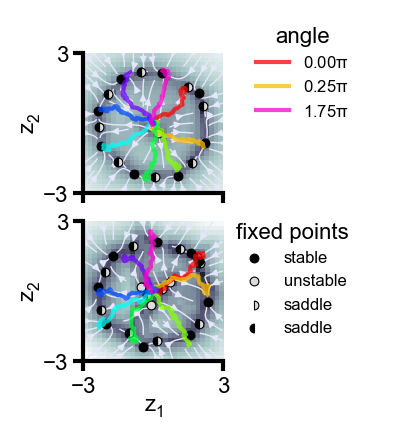

In [ ]:
# Make panel c

# marker style
dot_s = 10
dot_z = 100
dot_ew = 0.4
dot_s_st = 20
dot_fill = "gainsboro"

# for legend
angles = np.arange(0, 2 * np.pi, 2 * np.pi / task_params_teacher["n_stim"])

# colorful plot for phase plane
prop_cycle = [plt.cm.hsv(i) for i in np.arange(0, 1, 1 / len(angles))]

T1 = 0
T2 = dur

n_trials_plot = task_params_teacher["n_stim"]


with mpl.rc_context(fname="matplotlibrc"):
    fig, ax = plt.subplots(2, 2, figsize=(2, 2), dpi=200)

    # Teacher
    ax[0, 0].set_prop_cycle("color", prop_cycle)
    ax[0, 0].set_box_aspect(1)
    ax[0, 0].spines[["right", "top"]].set_visible(False)
    ax[0, 0].imshow(
        normGT,
        extent=[-xlims, xlims, -ylims, ylims],
        origin="lower",
        cmap="bone",
        vmax=np.max(norm),
        aspect="auto",
    )
    ax[0, 0].streamplot(
        X, Y, uGT, vGT, color="lavender", density=0.5, linewidth=0.5, arrowsize=0.5
    )
    ax[0, 0].set_xlim(-xlims, xlims)
    ax[0, 0].set_ylim(-ylims, ylims)
    ax[0, 0].set_xticks([-xlims, xlims])
    ax[0, 0].set_xticklabels([])
    ax[0, 0].set_yticks([-ylims, ylims])
    ax[0, 0].set_ylabel(r"$z_2$")
    ax[0, 0].plot(
        latent_codeGT[:n_trials_plot, 0].T,
        latent_codeGT[:n_trials_plot, 1].T,
        alpha=0.75,
        zorder=1000,
    )

    # for legend
    for ang_i in [0, 1, -1]:
        ax[0, 0].plot(
            latent_codeGT[ang_i,0, :1],
            latent_codeGT[ang_i,1, :1],
            alpha=0.75,
            label=f"{angles[ang_i]/(np.pi):.2f}$\pi$",
            zorder=-1,
            color=prop_cycle[ang_i],
        )
    ax[0, 0].legend(
        title="angle", loc="upper right", bbox_to_anchor=(2, 1.3), fontsize=6
    )

    ax[0, 1].set_box_aspect(1)
    ax[0, 1].axis("off")

    # Calculate stability of fixed points and plots
    for z in z_listGT:
        e, vec = np.linalg.eig(
            PL_Jacobian(V.numpy(), U.numpy(), B.numpy(), np.diag(np.ones(2) * 0.9), z)
        )
        if abs(e[0]) > 1 and abs(e[1]) > 1:
            ax[0, 0].scatter(
                z[0],
                z[1],
                s=dot_s,
                c=dot_fill,
                edgecolor="black",
                lw=dot_ew,
                marker=MarkerStyle("o"),
                zorder=dot_z,
            )
        elif abs(e[0]) < 1 and abs(e[1]) < 1:
            ax[0, 0].scatter(
                z[0],
                z[1],
                s=dot_s,
                c="black",
                edgecolor="black",
                lw=dot_ew,
                marker=MarkerStyle("o"),
                zorder=dot_z,
            )
        else:  # saddle
            ax[0, 0].scatter(
                z[0],
                z[1],
                s=dot_s,
                c=dot_fill,
                edgecolor="black",
                lw=dot_ew,
                marker=MarkerStyle("o", fillstyle="right"),
                zorder=dot_z,
            )
            ax[0, 0].scatter(
                z[0],
                z[1],
                s=dot_s,
                c="black",
                edgecolor="black",
                lw=dot_ew,
                marker=MarkerStyle("o", fillstyle="left"),
                zorder=dot_z,
            )

    # Student
    ax[1, 0].imshow(
        norm,
        extent=[-xlims, xlims, -ylims, ylims],
        origin="lower",
        cmap="bone",
        vmax=np.max(norm),
        aspect="auto",
    )
    ax[1, 0].streamplot(
        X, Y, u, v, color="lavender", density=0.5, linewidth=0.5, arrowsize=0.5
    )
    ax[1, 0].set_box_aspect(1)
    ax[1, 0].spines[["right", "top"]].set_visible(False)
    ax[1, 0].set_xlim(-xlims, xlims)
    ax[1, 0].set_ylim(-ylims, ylims)
    ax[1, 0].set_xticks([-xlims, xlims])
    ax[1, 0].set_yticks([-ylims, ylims])
    ax[1, 0].set_xlabel(r"$z_1$")
    ax[1, 0].set_ylabel(r"$z_2$")
    ax[1, 0].set_prop_cycle("color", prop_cycle)
    ax[1, 0].plot(
        Zn[:n_trials_plot, 0].T, Zn[:n_trials_plot, 1].T, alpha=0.75, zorder=1000
    )

    ax[1, 1].set_box_aspect(1)
    ax[1, 1].axis("off")

    # for legend
    incl_stable = False
    incl_saddle = False
    incl_unstable = False
    """"""
    # Calculate stability of fixed points and plots
    for z in z_list:
        e, vec = np.linalg.eig(PL_Jacobian(pV, pU, -pB, np.diag(np.ones(2) * tau), z))
        if abs(e[0]) > 1 and abs(e[1]) > 1:
            if incl_unstable:
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c=dot_fill,
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o"),
                    zorder=dot_z,
                )
            else:
                incl_unstable = True
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c=dot_fill,
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o"),
                    zorder=dot_z,
                    label="unstable",
                )
        elif abs(e[0]) < 1 and abs(e[1]) < 1:
            if incl_stable:
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c="black",
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o"),
                    zorder=dot_z,
                )
            else:
                incl_stable = True
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c="black",
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o"),
                    zorder=dot_z,
                    label="stable",
                )
        else:  # saddle
            if incl_saddle:
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c=dot_fill,
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o", fillstyle="right"),
                    zorder=dot_z - 1,
                )
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c="black",
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o", fillstyle="left"),
                    zorder=dot_z - 1,
                )
            else:
                incl_saddle = True
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c=dot_fill,
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o", fillstyle="right"),
                    zorder=dot_z - 1,
                    label="saddle",
                )
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c="black",
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o", fillstyle="left"),
                    zorder=dot_z - 1,
                    label="saddle",
                )
    ax[1, 0].legend(title="fixed points", loc="upper right", bbox_to_anchor=(2, 1.1))

    plt.savefig("../figures/Fig3C2.svg")

In [ ]:
data_gen.shape

(401, 60, 50)

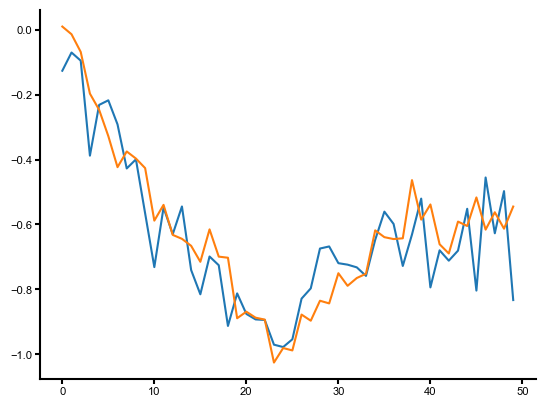

In [ ]:
plt.plot(data_gen[2, 30])
plt.plot(ratesGT[2,30])

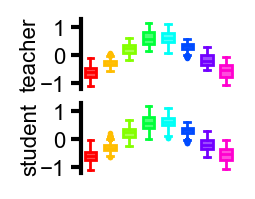

In [ ]:
# Make panel F

ni = np.random.randint(60)
n_st = task_params_teacher["n_stim"]

positions = np.arange(n_st)
t_st = 3
fig, ax = plt.subplots(2, 1, figsize=(1, 1), dpi=200, sharey=True)
for i in range(8):
    c = prop_cycle[i]

    ax[1].boxplot(
        data_gen[i::n_st, ni, t_st:].flatten(),
        positions=[i],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=cc.to_rgba(c, alpha=0.7), color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        medianprops=dict(color=c),
        flierprops={
            "marker": "o",
            "markersize": 1,
            "markerfacecolor": c,
            "markeredgecolor": c,
        },
    )
    ax[0].boxplot(
        ratesGT[ i::n_st, ni, t_st:].flatten(),
        positions=[i],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=cc.to_rgba(c, alpha=0.7), color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        medianprops=dict(color=c),
        flierprops={
            "marker": "o",
            "markersize": 1,
            "markerfacecolor": c,
            "markeredgecolor": c,
        },
    )
    ax[1].set_ylabel("student")
    ax[0].set_ylabel("teacher")
    # disable x axis spine
    ax[0].spines["bottom"].set_visible(False)
    ax[0].set_xticks([])
    ax[1].spines["bottom"].set_visible(False)
    # make ticks invisible
    ax[1].set_xticks([])

plt.savefig("../figures/Fig3F.svg")

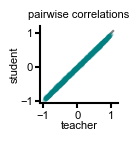

In [ ]:
# Supplementary

t_st = 3
data_gen_rs = np.transpose(data_gen[:, :, t_st:], (0, 2, 1)).reshape(-1, 60)
ratesGT_rs = np.transpose(ratesGT[:, :, t_st:], (0, 2, 1)).reshape(-1, 60)
test_correlation = calculate_correlation(ratesGT_rs)
gen_correlation = calculate_correlation(data_gen_rs)
i_upper = np.triu_indices(60, k=1)
test_corr_values = test_correlation[i_upper]
gen_corr_values = gen_correlation[i_upper]


# Plotting the scatter plot
plt.figure(figsize=(1, 1))
plt.scatter(
    test_corr_values, gen_corr_values, color="teal", alpha=0.1, linewidth=0, s=10
)
plt.title("pairwise correlations")
plt.xlabel("teacher")
plt.ylabel("student")
max = np.max([test_corr_values, gen_corr_values]) * 1.1
plt.plot([0, max], [0, max], color="grey", linestyle="--", zorder=-10)
plt.savefig("../figures/Supp_PWC.svg")